In [9]:
## Testing of w3j calculations and normalisations for binning scheme
# Code snippets from Test_binning_w3j.py

In [10]:
import numpy as np
import sys, os
import time
from numba import njit
sys.path.append('/home/amb257/software/cmplx_cmblensplus/wrap')
sys.path.append('/home/amb257/software/cmplx_cmblensplus/utils')
import curvedsky as cs
import basic
import matplotlib.pyplot as plt

In [11]:
# Functions to calculate the normalisation factor for a single multipole triplet and for all bins

def N(L1, L2, L3):
    """Compute the normalisation factor for a single triplet L1, L2, L3 used in binned bispec estimator"""
    w3j = basic.wigner_funcs.wigner_3j(L3,L2,0,0)
    lower_bound_w3j = np.abs(L3 - L2)
    position_L1_in_w3j = L1 - lower_bound_w3j
    if L1 >= lower_bound_w3j and np.abs(L1) <= np.abs(L3 + L2):
        N = (2*L1+1)*(2*L2+1)*(2*L3+1) * w3j[position_L1_in_w3j]**2 / (4*np.pi)
    else:
        print("L1 out of bounds")
        N = 0
    
    return N

def N_bin(bin_edges, is_it_folded):
    """Compute the normalisation factor for all bins"""
    size_bin_edges = len(bin_edges)

    if is_it_folded == False:
        changebins = 1
    else:
        changebins = 2
    
    N = np.zeros(size_bin_edges-1)
    sum = 0
    for index, item in enumerate(bin_edges[0:size_bin_edges-1]):
        sum = 0
        lower_bound_bin = int(item)
        upper_bound_bin = int(bin_edges[index+1])
        for l3 in range(int(lower_bound_bin/changebins), int(upper_bound_bin/changebins)):
            for l2 in range(int(lower_bound_bin/changebins), int(upper_bound_bin/changebins)):
                #First calculate the l bounds of w3j function (allowed l1 values given l2,3)
                lower_bound_w3j = np.abs(l3 - l2)
                upper_bound_w3j = l3 + l2
                #Calculate the w3j's
                w3j = basic.wigner_funcs.wigner_3j(l3,l2,0,0)
                for l1 in range(lower_bound_bin, upper_bound_bin):
                    if l1 >= lower_bound_w3j and l1 <= upper_bound_w3j: 
                        position_l1_in_w3j = l1 - lower_bound_w3j #this is the position of the current value of l1 in the w3j array
                        sum += (2*l1+1)*(2*l2+1)*(2*l3+1) * w3j[position_l1_in_w3j]**2 / (4*np.pi)
        N[index] = sum
    return N

In [12]:
# Test the normalisation factor for a single multipole triplet
L1, L2, L3 = 2, 2, 2
print("Normalisation factor for L1, L2, L3 = ", L1, L2, L3, "is", N(L1, L2, L3))
L1, L2, L3 = 30, 25, 35
print("Normalisation factor for L1, L2, L3 = ", L1, L2, L3, "is", N(L1, L2, L3))

Normalisation factor for L1, L2, L3 =  2 2 2 is 0.5684105110424833
Normalisation factor for L1, L2, L3 =  30 25 35 is 7.349372735684616


In [ ]:
# Test the normalisation factor for all bins (equilateral)
bin_edges = np.array([20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
is_it_folded = False
print("Normalisation factors for all bins (equilateral) are", N_bin(bin_edges, is_it_folded))


Normalisation factors for all bins (equilateral) are [2.96152264e+04 4.74882728e+04 0.00000000e+00 6.59835537e+04
 8.45915824e+04 1.85250040e+07 2.96839953e+07 4.12421860e+07
 5.28715836e+07 6.45285613e+07 7.61993604e+07 8.78781342e+07
 9.95619468e+07 1.11249154e+08]


In [14]:
# vectorised function to calculate the normalisation factor for all bins
def N_bin_vectorized(bin_edges, is_it_folded):
    size_bin_edges = len(bin_edges)
    changebins = 2 if is_it_folded else 1
    N = np.zeros(size_bin_edges - 1)
    
    for index in range(size_bin_edges - 1):
        lower_bound_bin = int(bin_edges[index])
        upper_bound_bin = int(bin_edges[index + 1])
        
        # Generate arrays of all possible l values in the range
        l2_range = np.arange(lower_bound_bin // changebins, upper_bound_bin // changebins)
        l3_range = np.arange(lower_bound_bin // changebins, upper_bound_bin // changebins)
        l1_range = np.arange(lower_bound_bin, upper_bound_bin)
        
        # Create factors arrays (2l+1)
        l1_factors = 2 * l1_range + 1
        l2_factors = 2 * l2_range + 1
        l3_factors = 2 * l3_range + 1
        
        # Initialize bin_sum
        bin_sum = 0
        
        for l3 in l3_range:
            for l2 in l2_range:
                # Calculate w3j bounds
                lower_bound_w3j = abs(l3 - l2)
                upper_bound_w3j = l3 + l2
                
                # Get w3j values
                w3j = basic.wigner_funcs.wigner_3j(l3, l2, 0, 0)
                
                # Get valid l1 values
                valid_mask = (l1_range >= lower_bound_w3j) & (l1_range <= upper_bound_w3j)
                valid_l1 = l1_range[valid_mask]
                
                if len(valid_l1) > 0:
                    # Calculate positions of l1 values in w3j array
                    positions = valid_l1 - lower_bound_w3j
                    
                    # Get corresponding w3j values and factors
                    w3j_values_squared = np.array([w3j[pos]**2 for pos in positions])
                    valid_l1_factors = l1_factors[valid_mask]
                    
                    # Accumulate sum
                    bin_sum += np.sum(valid_l1_factors * (2*l2+1) * (2*l3+1) * w3j_values_squared) / (4*np.pi)
        
        N[index] = bin_sum
        
    return N

In [15]:
# Test the normalisation factor for all bins (equilateral)
bin_edges = np.array([20, 40, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
is_it_folded = False
N_bin_result = N_bin_vectorized(bin_edges, is_it_folded)
print("Normalisation factors for all bins (equilateral) are", N_bin_result)

Normalisation factors for all bins (equilateral) are [2.96152264e+04 4.74882728e+04 6.59835537e+04 8.45915824e+04
 1.85250040e+07 2.96839953e+07 4.12421860e+07 5.28715836e+07
 6.45285613e+07 7.61993604e+07 8.78781342e+07 9.95619468e+07
 1.11249154e+08]


Text(0, 0.5, 'Normalisation factor')

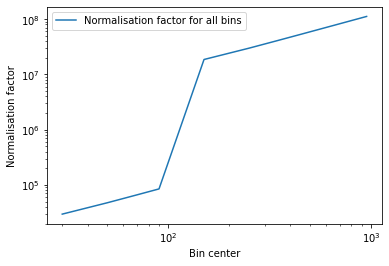

In [16]:
# Plot the normalisation factor for all bins (equilateral)
bin_mid = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.loglog(bin_mid, N_bin_result, label='Normalisation factor for all bins')
plt.legend()
plt.xlabel('Bin center')
plt.ylabel('Normalisation factor')